## Initialization with the prepared dataset `elephants_dream`
Initialize Rikai Spark Session and then load the prepared `elephants_dream` dataset.

NOTE: please run `python elephants_dream.py` first to prepare the dataset to `/tmp/rikai_example/elephants_dream`

In [1]:
from example import spark

:: loading settings :: url = jar:file:/Users/da/.pyenv/versions/3.8.10/envs/rikai-example/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/da/.ivy2/cache
The jars for the packages stored in: /Users/da/.ivy2/jars
ai.eto#rikai_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c8ebf1ea-39dd-4d95-825a-78f7fc5dff1c;1.0
	confs: [default]
	found ai.eto#rikai_2.12;0.0.13-SNAPSHOT in local-ivy-cache
	found org.antlr#antlr4-runtime;4.8-1 in local-m2-cache
	found org.bytedeco#javacpp;1.5.6 in central
	found org.bytedeco#ffmpeg;4.4-1.5.6 in central
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.apache.logging.log4j#log4j-api-scala_2.12;12.0 in central
	found org.scala-lang#scala-reflect;2.12.10 in spark-list
	found org.apache.logging.log4j#log4j-api;2.13.2 in central
	found io.circe#circe-core_2.12;0.12.3 in central
	found io.circe#circe-numbers_2.12;0.12.3 in central
	found org.typelevel#cats-core_2.12;2.0.0 in central
	found org.typelevel#cats-macros_2.12;2.0.0 in central
	found org.typelevel#cats-kernel_2.12;2.0.0 in central
	found io.c

In [2]:
df = spark.read.format('parquet').load('/tmp/rikai_example/elephants_dream')
# df = spark.read.format("video").load("elephants_dream.mp4")
df.createOrReplaceTempView("elephants_dream")

spark.sql("""
select count(*) from elephants_dream
""").show()

+--------+
|count(1)|
+--------+
|   15691|
+--------+



In [3]:
from rikai.types.vision import Image
samples_df = spark.sql("""
select frame_id, image_data from elephants_dream
""").limit(10)

samples = samples_df.collect()
samples_df.show()

+--------+--------------------+
|frame_id|          image_data|
+--------+--------------------+
|   12640|[89 50 4E 47 0D 0...|
|   15411|[89 50 4E 47 0D 0...|
|   11832|[89 50 4E 47 0D 0...|
|    6371|[89 50 4E 47 0D 0...|
|   14382|[89 50 4E 47 0D 0...|
|   10898|[89 50 4E 47 0D 0...|
|   11711|[89 50 4E 47 0D 0...|
|    4387|[89 50 4E 47 0D 0...|
|   12108|[89 50 4E 47 0D 0...|
|   13130|[89 50 4E 47 0D 0...|
+--------+--------------------+



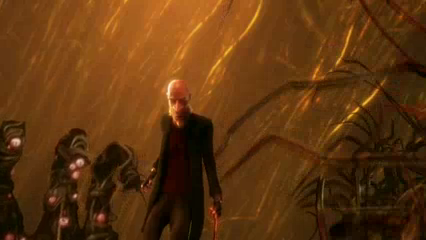

In [4]:
Image(samples[0].image_data)

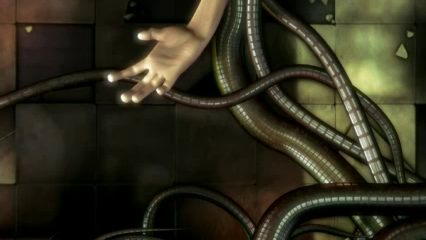

In [5]:
Image(samples[9].image_data)

## Create the Yolov5 model and register the necessary UDFs

Please run `python yolov5_mlflow.py` first.

In [6]:
mlflow_tracking_uri = "sqlite:///mlruns.db"
registered_model_name = f"yolov5s-model"

spark.conf.set("rikai.sql.ml.registry.mlflow.tracking_uri", mlflow_tracking_uri)

spark.sql(f"""
    CREATE OR REPLACE MODEL mlflow_yolov5_m
    PREPROCESSOR 'rikai.contrib.torch.transforms.yolov5.pre_processing'
    POSTPROCESSOR 'rikai.contrib.torch.transforms.yolov5.post_processing'
    USING 'mlflow:///{registered_model_name}';
""")


2021-11-03 15:07:42,311 INFO Rikai (mlflow_registry.py:223): Resolving model mlflow_yolov5_m from mlflow:///yolov5s-model
2021-11-03 15:07:43,151 INFO Rikai (base.py:207): Created model inference pandas_udf with name mlflow_yolov5_m_e617418d


DataFrame[]

In [7]:
# Inspect Bounding Boxes on an Image
from rikai.types.vision import Image
from rikai.spark.types.vision import ImageType
from rikai.types.geometry import Box2d
from pyspark.sql.functions import udf
from PIL import ImageDraw

@udf(returnType=ImageType())
def inspect_bounding_boxes(img: Image, boxes, labels):
    pil_image = img.to_pil()
    draw = ImageDraw.Draw(pil_image)
    for i in range(len(labels)):
        box = boxes[i]
        label = labels[i]
        bbox = Box2d(box[0], box[1], box[2], box[3])
        draw.rectangle(bbox.to_numpy().tolist(), outline="green", width=2)
        draw.text([bbox.xmin + 5, bbox.ymin - 10], str(label), fill="red")
    return Image.from_pil(pil_image)

spark.udf.register("inspect_bbox", inspect_bounding_boxes)

<function __main__.inspect_bounding_boxes(img: rikai.types.vision.Image, boxes, labels)>

In [8]:
from rikai.spark.functions.vision import to_image
spark.udf.register("to_image", to_image)

<function rikai.spark.functions.vision.to_image(image_data: Union[bytes, bytearray, str, pathlib.Path]) -> rikai.types.vision.Image>

## Apply ML_PREDICT on frames

In [9]:
predicts = spark.sql("""
from (
    from (
        select
            frame_id,
            image_data,
            ML_PREDICT(mlflow_yolov5_m, image_data) as pred 
        from elephants_dream
        where frame_id = 12640
    )
    select
        frame_id,  
        pred,
        to_image(image_data) as image
)
select
    *,
    inspect_bbox(image, pred.boxes, pred.label_ids) as bbox
""")
rows = predicts.collect()

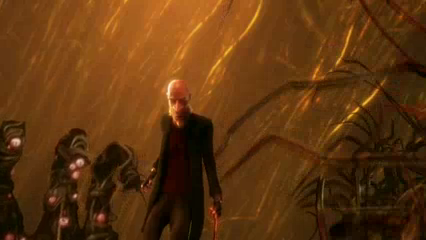

In [10]:
rows[0].image

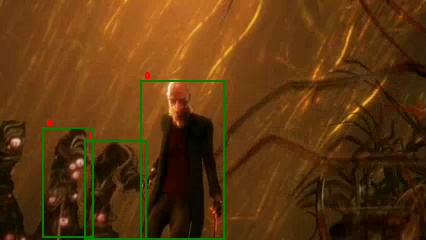

In [11]:
rows[0].bbox

In [12]:
rows[0].pred

Row(boxes=[[140.40493774414062, 80.37430572509766, 224.85302734375, 239.52894592285156], [84.92842864990234, 140.91220092773438, 146.51467895507812, 239.2635040283203], [42.036197662353516, 127.1123275756836, 93.83756256103516, 237.881591796875]], scores=[0.8146845102310181, 0.588811993598938, 0.4002956449985504], label_ids=[0, 0, 0])